In [11]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
from scipy.special import logsumexp
import pandas as pd
import numpy
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
# from nn_models import Feedforward
# from bayesian_regression import Bayesian_Regression

from normflows import flows
from tqdm import tqdm_notebook as tqdm
import sys
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Assume that the outcome $y$ can be modeled by the following process:
\begin{aligned}
y &= f(x) + \epsilon = w_1x + w_0 + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}


$$\log \left[ \left(\prod_{n=1}^Np(y_n|x_n, \textbf{w})\right) p(\textbf{w}) \right] = -\frac{1}{2}\textbf{w}^T\left( \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \right)\textbf{w} + \textbf{w}^T \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right) + const.$$

Since we know this is a quadratic exponential and is Guassian, comparing with a standard multivariate Gaussian, the posterior is a bivariate Gaussian $\textbf{w} \sim \mathcal{N}(\mu_{post}, \Sigma_{post})$, where

$$\begin{aligned}
    \Sigma_{post} ^{-1} &= \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \\
    \mu_{post} &= \Sigma_{post} \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right)
\end{aligned}
$$

In this particular case, 

$$\Sigma_{post} ^{-1} = \begin{bmatrix}
    1 & 0 \\
    0 & 0.5
  \end{bmatrix}^{-1} + \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N \begin{bmatrix}
    1\\
    x_n
  \end{bmatrix} \begin{bmatrix}
    1 & x_n
  \end{bmatrix} = \begin{bmatrix}
    1+\frac{N}{\sigma_{\epsilon}^2} & \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n \\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n & 2+\frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n^2
  \end{bmatrix}$$
  
whereas the terms inside the brackets for $\mu_{post}$ are
  
$$\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} = 0 + \begin{bmatrix}
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N y_n\\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_ny_n
  \end{bmatrix}$$

In [64]:
#Read in the data
df = pd.read_csv('data/HW0_data.csv')
X = df['x'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)
X_mat = sm.add_constant(X)

In [65]:
#Construct the derived posterior inverse covariance matrix from above
cov_postinv = np.zeros([2,2])
cov_postinv[0][0] = 1 + len(X)/0.5
cov_postinv[0][1] = X.sum()/0.5
cov_postinv[1][0] = X.sum()/0.5
cov_postinv[1][1] = 2 + (X**2).sum()/0.5
#Get the covariance by taking the inverse
cov_post = np.linalg.inv(cov_postinv)

#Construct the vector within the brackets for mu_post from above
vector = np.zeros([2,1])
vector[0] = y.sum()/0.5
vector[1] = (X*y).sum()/0.5
#Get the posterior mean
mu_post = np.matmul(cov_post, vector)

In [66]:
mu_post

array([[8.81958297],
       [5.21603948]])

In [68]:
D = 2
N = X_mat.shape[0]
sigma_e = 0.5
params = variational_inference(np.array([[1,0],[0,0.5]]),sigma_e, y, X_mat, forward, S=1000, \
                               max_iteration=1000, step_size=1e-1, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -30539.466056153142; gradient mag: 152.62214679327647
Iteration 100 lower bound -30536.363573139875; gradient mag: 4.263828645164401
Iteration 200 lower bound -30536.41529699454; gradient mag: 5.2189788551913905
Iteration 300 lower bound -30536.399523534914; gradient mag: 4.536858396887439
Iteration 400 lower bound -30536.400756914736; gradient mag: 12.99753436814084
Iteration 500 lower bound -30536.465640433682; gradient mag: 12.43011565086504
Iteration 600 lower bound -30536.41793852928; gradient mag: 25.94459523568
Iteration 700 lower bound -30536.39405035595; gradient mag: 10.57352972331591
Iteration 800 lower bound -30536.385576378372; gradient mag: 3.887746753029703
Iteration 900 lower bound -30536.468270997004; gradient mag: 1.1049825733521936


In [69]:
mu_VI = params[:D]
cov_VI = np.diag(np.exp(params[D:])**2)

In [70]:
mu_VI, mu_post

(array([8.84104446, 5.21864052]), array([[8.81958297],
        [5.21603948]]))

Text(0.5, 1.0, 'True posterior (in red) vs. VI posterior (in blue)')

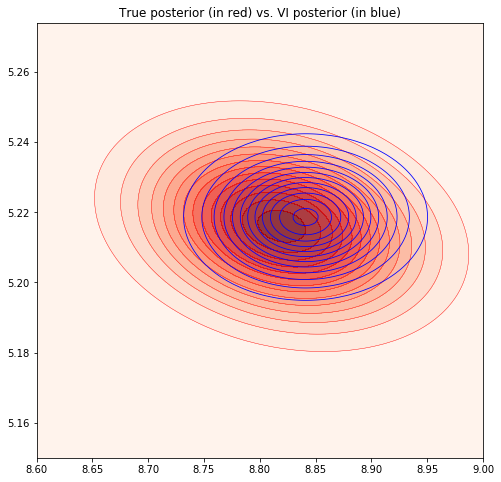

In [71]:
x, y = numpy.mgrid[8.6:9:.001, 5.15:5.275:.001]
pos = numpy.dstack((x, y))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

z = scipy.stats.multivariate_normal(mu_post.flatten(), cov_post).pdf(pos)
z_VI = scipy.stats.multivariate_normal(mu_VI, cov_VI).pdf(pos)

ax.contourf(x, y, z, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z, levels=14, linewidths=0.4, colors='red')

ax.contour(x, y, z_VI, levels=14, linewidths=0.8, colors='blue')
plt.title('True posterior (in red) vs. VI posterior (in blue)')

In [146]:
ndim = 2
mu0 = np.zeros(ndim)
Sigma0 = np.eye(ndim)
N = 1000
# nbins = 300

samples = np.random.multivariate_normal(mu0, Sigma0, size=N)

In [5]:
def w1(z):
    return np.sin(2*np.pi*z[0]/4)

def w2(z):
    first = (z[0]-1)/0.6
    return 3*np.exp(-0.5*first**2)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def w3(z):
    first = (z[0]-1)/0.3
    return 3*sigmoid(first)

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    first = (np.linalg.norm(z)-2)/0.4
    second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
    third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
    
    return np.exp(-0.5*first**2 + np.log(second+third))

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    first = (z[1] - w1(z))/0.4
    return np.exp(-0.5*first**2)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.35)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w2(z))/0.35)**2)
    
    return first+second

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.4)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w3(z))/0.35)**2)
    
    return first+second

def neg_u1(z):
    '''Apply U_1 to bivariate z.'''
    first = (np.linalg.norm(z)-2)/0.4
    second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
    third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
    
    return -0.5*first**2 + np.log(second+third)

def neg_u2(z):
    '''Apply U_2 to bivariate z.'''
    first = (z[1] - w1(z))/0.4
    return -0.5*first**2

def neg_u3(z):
    '''Apply U_3 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.35)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w2(z))/0.35)**2)
    
    return np.log(first+second)

def neg_u4(z):
    '''Apply U_4 to bivariate z.'''
    first = np.exp(-0.5*((z[1] - w1(z))/0.4)**2)
    second = np.exp(-0.5*((z[1] - w1(z) + w3(z))/0.35)**2)
    
    return np.log(first+second)

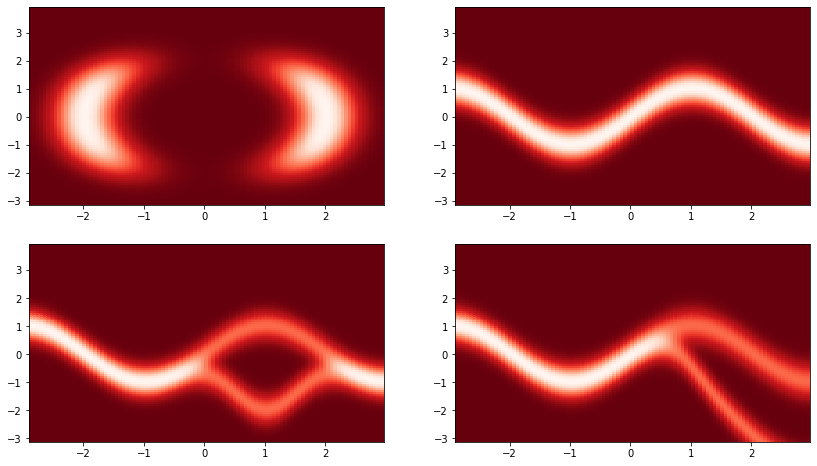

In [148]:
fig,ax=plt.subplots(2,2,figsize = (14,8))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
# density = scipy.stats.kde.gaussian_kde([x, y])
xi, yi = numpy.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = np.array([p1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p2(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p3(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

zi = np.array([p4(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)

In [22]:
def gradient_create(logq0, logp, hprime, logdet_jac, free_energy, dim_z, num_samples, K):

    def unpack_params(params):
        mu0 = params[:dim_z]
        log_sigmadiag0 = params[dim_z:2*dim_z]
        W = params[2*dim_z:2*dim_z+K*dim_z].reshape(K,dim_z)
        U = params[2*dim_z+K*dim_z:2*dim_z+2*K*dim_z].reshape(K,dim_z)
        b = params[-K:]
        return mu0, log_sigmadiag0, W,U,b

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mu0, log_sigmadiag0, W,U,b = unpack_params(params)
        z0 = rs.randn(num_samples, dim_z) * np.sqrt(np.exp(log_sigmadiag0)) + mu0
        fe = free_energy(z0, mu0, log_sigmadiag0, W,U,b, logq0, logp, dim_z, num_samples, K, t)
        return fe

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

def optimise(logp, dim_z, num_samples, K, max_iteration, step_size, verbose):

    def logq0(z):
        '''0,1 Gaussian.'''
        D = z.shape[0]
        return -D/2 * np.log(2*np.pi) - 0.5*np.sum(z**2, axis=0)
    
    def hprime(x, h='tanh'):
        if h=='tanh':
            return 1 - np.tanh(x)**2
    
    def logdet_jac(w, z, b):
        return np.outer(w, hprime(np.matmul(w, z) + b))
    
    def planar_flow(z,w,u,b,h=np.tanh):
        """Apply a planar flow to each element of `samples`

        :param z: numpy array, samples to be transformed
            Shape: (n_samples, n_dim)
        :param u: numpy array, parameter of flow
        :param w: numpy array, parameter of flow
        :param b: numeric, parameter of flow
        :param h: callable, non-linear function (default tanh)
        :returns: numpy array, transformed samples

        Transforms given samples according to the planar flow
        :math:`f(z) = z + uh(w^Tz + b)`
        """
        if h == np.tanh:
            u = _get_uhat(u, w)
            assert np.dot(u, w) >= -1, f'Flow is not guaranteed to be invertible (u^Tw < -1: {w._value, u._value})'

        w = w.flatten()
        u = u.flatten()

        assert z.ndim == 2, f'z has incorrect number of dimensions ({z.ndim}).'

        N = z.shape[0]
        d = z.shape[1]

        assert d == w.shape[0], f'Dimensions of z and w are not aligned ({d} != {w.shape[0]}).'
        assert d == u.shape[0], f'Dimensions of z and u are not aligned ({d} != {u.shape[0]}).'

        dotprod = np.dot(w, z.T)
        h_arg = dotprod + b
        h_res = np.repeat(h(h_arg).reshape(-1, 1), d, axis=1)
        u_mult = u * h_res
        res = z + u_mult.reshape(N, d)
        return res


    def _get_uhat(u, w):
        return u + (m(np.dot(w, u)) - np.dot(w, u)) * (w/np.linalg.norm(w))


    def m(x):
        return -1 + np.log(1 + np.exp(x))

    
    def free_energy(z0, mu0, log_sigmadiag0, W,U,b, logq0, logp, dim_z, num_samples, K,t):
        '''
        logp: log p(x, z_K) likelihood function parameterised by theta.
        logq0: log PDF of initial samples.
        W: a K x dim_z matrix, with flow parameter w_k per row.
        U: a K x dim_z matrix, with flow parameter u_k per row.
        b: a K dimensional vector, with flow parameter b_k.
        z0: a num_samples, dim_z array, of initial z_0''' 
        
        first = np.mean(logq0(z0.T))
        
        z=z0
        middle = 0
        for k in range(K):
            middle += np.log(np.abs(1 + np.dot(U[k], logdet_jac(W[k], z.T, b[k]))))
#             z += np.outer(np.tanh(np.dot(W[k], z.T) + b[k]), U[k])
            z = flows.planar_flow(z, W[k], U[k], b[k])
            
        second = np.mean(logp(z.T))

        third = np.mean(middle)

        return first - second - third

    objective, gradient, unpack_params = gradient_create(logq0, logp, hprime, logdet_jac, \
                                        free_energy, dim_z, num_samples, K)
    
    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {}; gradient mag: {}".format(t, np.linalg.norm(gradient(params, t))))
#                 print("Iteration {}; gradient mag: {}".format(t, gradient(params, t)))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mu0 = np.zeros((dim_z))
    init_logsigma0 = 0*np.ones((dim_z))
    init_W = np.ones((K,dim_z))
    init_U = np.ones((K,dim_z))

#     init_W = np.array([[-4.9, 0]])
#     init_U = np.array([[-4.9, 0]])
    while np.any(np.diag(np.matmul(init_W,init_U.T))<-1):
        init_U = np.ones((K,dim_z))
        
    init_b = np.zeros((K))

    init_params = np.concatenate([init_mu0, init_logsigma0, init_W.flatten(), init_U.flatten(), init_b])
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params

In [25]:
dim_z=2
num_samples=10000
K=2
params = optimise(neg_u1, dim_z, num_samples, K, 180, 1e-2, True)

Optimizing variational parameters...
Iteration 0; gradient mag: 124099.40383672982
Iteration 100; gradient mag: 18224.78274254487


In [26]:
def unpack_params(params):
    mu0 = params[:dim_z]
    log_sigmadiag0 = params[dim_z:2*dim_z]
    W = params[2*dim_z:2*dim_z+K*dim_z].reshape(K,dim_z)
    U = params[2*dim_z+K*dim_z:2*dim_z+2*K*dim_z].reshape(K,dim_z)
    b = params[-K:]
    return mu0, log_sigmadiag0, W,U,b

mu0, log_sigmadiag0, W,U,b = unpack_params(params)

In [27]:
mu0, log_sigmadiag0, W, U, b

(array([ 0.00352157, -0.00257932]),
 array([-1.06405414, -1.06373138]),
 array([[2.08971979, 2.0352524 ],
        [1.92981111, 1.99473887]]),
 array([[0.26506088, 0.27050209],
        [0.28059383, 0.26452273]]),
 array([-0.02344219,  0.00318713]))

In [28]:
Z = np.zeros((K+1, num_samples, dim_z))
rs = npr.RandomState(0)
z = rs.randn(num_samples, dim_z) * np.sqrt(np.exp(log_sigmadiag0)) + mu0
Z[0] = z
for k in range(K):
    z = flows.planar_flow(z, W[k], U[k], b[k])
    Z[k+1] = z

In [29]:
Z.shape

(3, 10000, 2)

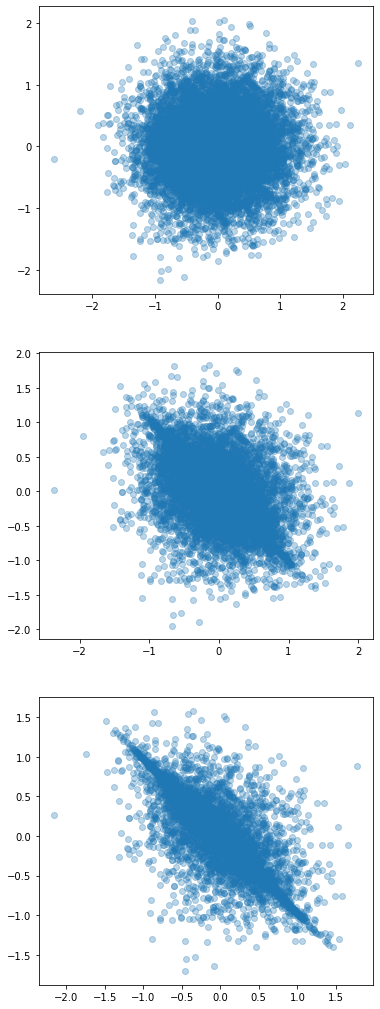

In [30]:
fig, ax = plt.subplots(K+1,1,figsize=(6,6*(K+1)))
for i in range(K+1):
    ax[i].scatter(Z[i, :, 0], Z[i, :, 1], alpha=0.3)
    
plt.show()

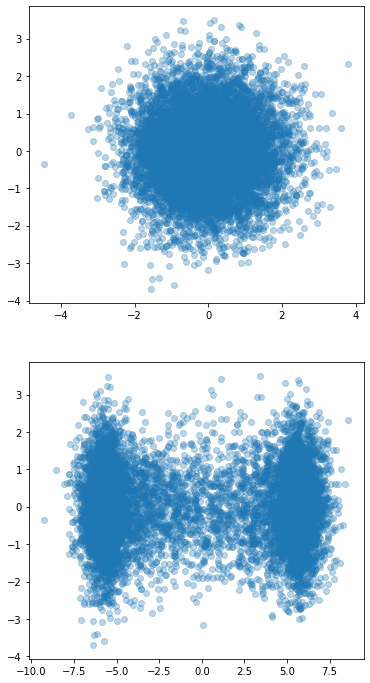

In [146]:
w_mine = np.array([[-5.0, 0.0]])
u_mine = np.array([[-5.0, 0.0]])
b_mine = np.array([0])

Z = np.zeros((2, 10000, 2))
rs = npr.RandomState(0)
z = rs.randn(10000, dim_z)
Z[0] = z
Z[1] = flows.planar_flow(z, w_mine[0], u_mine[0], b_mine[0])

fig, ax = plt.subplots(2,1,figsize=(6,6*(1+1)))
for i in range(1+1):
    ax[i].scatter(Z[i, :, 0], Z[i, :, 1], alpha=0.3)
    
plt.show()

In [22]:
def logq0(z):
    '''0,1 Gaussian.'''
    D = z.shape[0]
    return -D/2 * np.log(2*np.pi) - 0.5*np.sum(z**2, axis=0)

def hprime(x, h='tanh'):
    if h=='tanh':
        return 1/np.cosh(x)**2

def logdet_jac(w, z, b):
    return np.outer(w, hprime(np.matmul(w, z) + b))

def logp_mine(z):
    first = logq0(z)
    middle = np.log(np.abs(1 + np.dot(np.array([-5.0, 0.0]), logdet_jac(np.array([-5.0, 0.0]), z, 0))))

    return first - middle

In [26]:
dim_z=2
num_samples=10000
K=1
params = optimise(logp_mine, dim_z, num_samples, K, 3000, 1e-4, True)

Optimizing variational parameters...
Iteration 0; gradient mag: 0.4971203008826365
Iteration 100; gradient mag: 0.4841530746722487
Iteration 200; gradient mag: 0.4509346794843445
Iteration 300; gradient mag: 0.4522708452242351
Iteration 400; gradient mag: 0.4357193694054894
Iteration 500; gradient mag: 0.4260070911351022
Iteration 600; gradient mag: 0.4310778638048366
Iteration 700; gradient mag: 0.4054841458436767
Iteration 800; gradient mag: 0.3954246380988288
Iteration 900; gradient mag: 0.39911071873264814
Iteration 1000; gradient mag: 0.38916615201874577
Iteration 1100; gradient mag: 0.37019959857248813
Iteration 1200; gradient mag: 0.3707238220089447
Iteration 1300; gradient mag: 0.36026674536412023
Iteration 1400; gradient mag: 0.3469758873527513
Iteration 1500; gradient mag: 0.34879843776208574
Iteration 1600; gradient mag: 0.32421072387276023
Iteration 1700; gradient mag: 0.3097452156456636
Iteration 1800; gradient mag: 0.29662815071683485
Iteration 1900; gradient mag: 0.29871

In [27]:
mu0, log_sigmadiag0, W,U,b = unpack_params(params)

In [28]:
mu0, log_sigmadiag0, W, U, b

(array([ 0.0052369 , -0.00461065]),
 array([ 0.31686267, -0.25948017]),
 array([[1.22626762, 1.28555792]]),
 array([[0.79583373, 0.74804496]]),
 array([-0.00086073]))

In [29]:
Z = np.zeros((K+1, num_samples, dim_z))
rs = npr.RandomState(0)
z = rs.randn(num_samples, dim_z) * np.sqrt(np.exp(log_sigmadiag0)) + mu0
Z[0] = z
for k in range(K):
    z = flows.planar_flow(z, W[k], U[k], b[k])
    Z[k+1] = z

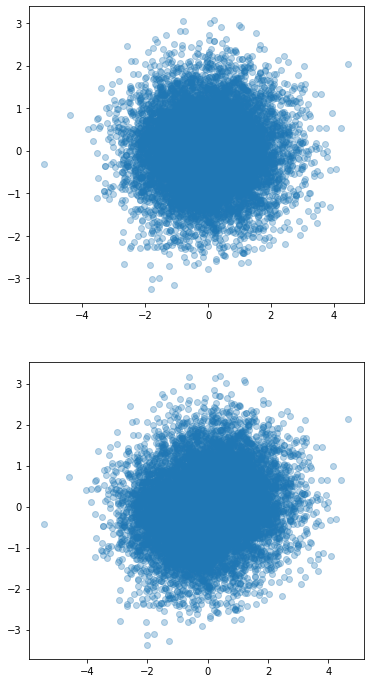

In [30]:
fig, ax = plt.subplots(K+1,1,figsize=(6,6*(K+1)))
for i in range(K+1):
    ax[i].scatter(Z[i, :, 0], Z[i, :, 1], alpha=0.3)
    
plt.show()